## Imports

In [226]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import math

import statsmodels.api as sm
from statsmodels.api import OLS

#SKLearn stuff
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler,PolynomialFeatures,OrdinalEncoder,OneHotEncoder,power_transform
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

warnings.filterwarnings('ignore')

In [227]:
df = pd.read_csv('data/kc_house_data.csv')

# Header cleaning. More precautionary than anything else
df.columns = [x.strip().lower().replace(' ','').replace('-','') for x in df.columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [228]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


## Remove outliers

{'whiskers': [<matplotlib.lines.Line2D at 0x1c6bc1387f0>,
 'caps': [<matplotlib.lines.Line2D at 0x1c6bc138eb0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c6bc138490>],
 'medians': [<matplotlib.lines.Line2D at 0x1c6bc1505b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c6bc150910>],
 'means': []}

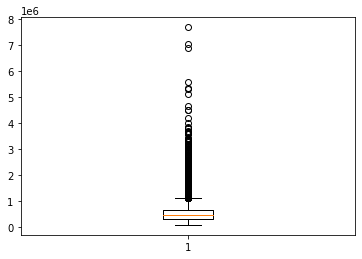

In [4]:
plt.boxplot(df.price)

In [232]:
df.view.isna().sum()

58

In [230]:
# Zach's code
price_q75, price_q25 = np.percentile(df['price'],[75,25])
intr_qrt = price_q75-price_q25
upper_price = price_q75 + (1.5*intr_qrt)
lower_price = price_q25 - (1.5*intr_qrt)
lower_price, upper_price
df = df[df['price'] <= upper_price]
df = df[df['price'] >= lower_price]

In [231]:
# Removing outliers
df = df[df['bedrooms'] <=15] #2 records remove. 33 BR home
df = df[df['grade'] != '3 Poor'] #only 1 instance of this exists


## Data Cleaning

In [7]:
df.bedrooms

0        3
1        3
2        2
3        4
4        3
        ..
21592    3
21593    4
21594    2
21595    3
21596    2
Name: bedrooms, Length: 20437, dtype: int64

In [8]:
#Making a categorical bedroom columns
df['bedrooms_bin']=pd.cut(df['bedrooms'], bins = [0,1,2,3,4,5,6,99], labels=['1BR','2BR','3BR','4BR','5BR','6BR','7+BR'])

In [9]:
df['bedrooms_bin']

0        3BR
1        3BR
2        2BR
3        4BR
4        3BR
        ... 
21592    3BR
21593    4BR
21594    2BR
21595    3BR
21596    2BR
Name: bedrooms_bin, Length: 20437, dtype: category
Categories (7, object): ['1BR' < '2BR' < '3BR' < '4BR' < '5BR' < '6BR' < '7+BR']

In [10]:
df.bedrooms_bin.value_counts()

3BR     9597
4BR     6304
2BR     2736
5BR     1335
6BR      225
1BR      194
7+BR      46
Name: bedrooms_bin, dtype: int64

(array([ 194., 2736., 9597., 6304., 1335.,  225.,   46.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <BarContainer object of 7 artists>)

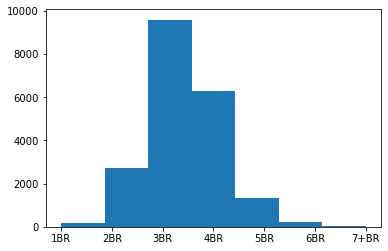

In [11]:
plt.hist(df.bedrooms_bin.sort_values(),bins = 7)

sqft_basement is an object?

In [13]:
df.sqft_basement.sort_values()

0        0.0
12682    0.0
12685    0.0
12686    0.0
12687    0.0
        ... 
1205       ?
9715       ?
12933      ?
19777      ?
4171       ?
Name: sqft_basement, Length: 20437, dtype: object

sqft_basement is a list of strings that include some unknowns marked as '?'

In [14]:
len(df[df.sqft_basement=='?']) /len(df)

0.02113813181973871

In [15]:
df_subset_basement = df[df.sqft_basement !='?'] #subset of  records where sqft_basement is not '?'
df_subset_basement.sqft_basement = df_subset_basement.sqft_basement.astype(float,)

In [16]:
#check to see how much of the current sqft_basement (excluding '?') can be explained by (sqft_living-sqft_above)

(df_subset_basement.sqft_living - df_subset_basement.sqft_above == df_subset_basement.sqft_basement).sum()/df_subset_basement.shape[0]

1.0

So, 98% of the sqft_basement data has a value in it which can be explained using this math. The remaining missing data is filled with '?'. Fill using this math

In [17]:
df['sqft_basement'] = df['sqft_living'] - df['sqft_above']

In [18]:
# # Change view rating to a numeric value. Probably don't need it
# df['view'] = df['view'].map({'EXCELLENT':5,
#                              'GOOD':4,
#                              'AVERAGE':3,
#                              'FAIR':2,
#                              'NONE':1})

# # Change condition rating to a numeric value. Probably don't need it
# df['condition'] = df['condition'].map({'Very Good':5,
#                                        'Good':4,
#                                        'Average':3,
#                                        'Fair':2,
#                                        'Poor':1})

# # Changing grade to just the numeric value of the grade
# df['grade'] = df['grade'].str.split(' ').str[0].astype(int)

In [233]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20437 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             20437 non-null  int64  
 1   date           20437 non-null  object 
 2   price          20437 non-null  float64
 3   bedrooms       20437 non-null  int64  
 4   bathrooms      20437 non-null  float64
 5   sqft_living    20437 non-null  int64  
 6   sqft_lot       20437 non-null  int64  
 7   floors         20437 non-null  float64
 8   waterfront     18168 non-null  object 
 9   view           20379 non-null  object 
 10  condition      20437 non-null  object 
 11  grade          20437 non-null  object 
 12  sqft_above     20437 non-null  int64  
 13  sqft_basement  20437 non-null  object 
 14  yr_built       20437 non-null  int64  
 15  yr_renovated   16810 non-null  float64
 16  zipcode        20437 non-null  int64  
 17  lat            20437 non-null  float64
 18  long  

In [20]:
#The number of records where view is nan is 0.29% of the dataset. Hence dropped
print(df.view.isna().sum() /df.shape[0])
df.dropna(subset=['view'],inplace=True)

0.002837989920242697


## Analyzing Corelations

In [21]:
df.corr().price.sort_values()

zipcode         -0.018555
id               0.010250
yr_built         0.061387
long             0.072725
sqft_lot15       0.082488
yr_renovated     0.089741
sqft_lot         0.093572
sqft_basement    0.233010
floors           0.273611
bedrooms         0.300831
lat              0.431021
bathroom_log     0.436524
bathrooms        0.455204
sqft_above       0.530569
sqft_living15    0.561947
sqft_living      0.621509
price            1.000000
Name: price, dtype: float64

dropping yr_renovated . not enough records

dropping id, yr_built, floors, date, sqft_lot, sqft_lot15. Not enough correlation. Making predictions based on other columns

stakeholder: potential investor, homebuyer

keeping zipcode, lat, long for the purpose of potential visualizations

In [22]:
df = df.drop(columns = ['id','yr_renovated','floors','date'],axis =1)

In [23]:
df.grade.value_counts()

7 Average        8935
8 Good           5931
9 Better         2308
6 Low Average    2030
10 Very Good      764
5 Fair            242
11 Excellent      137
4 Low              27
12 Luxury           5
Name: grade, dtype: int64

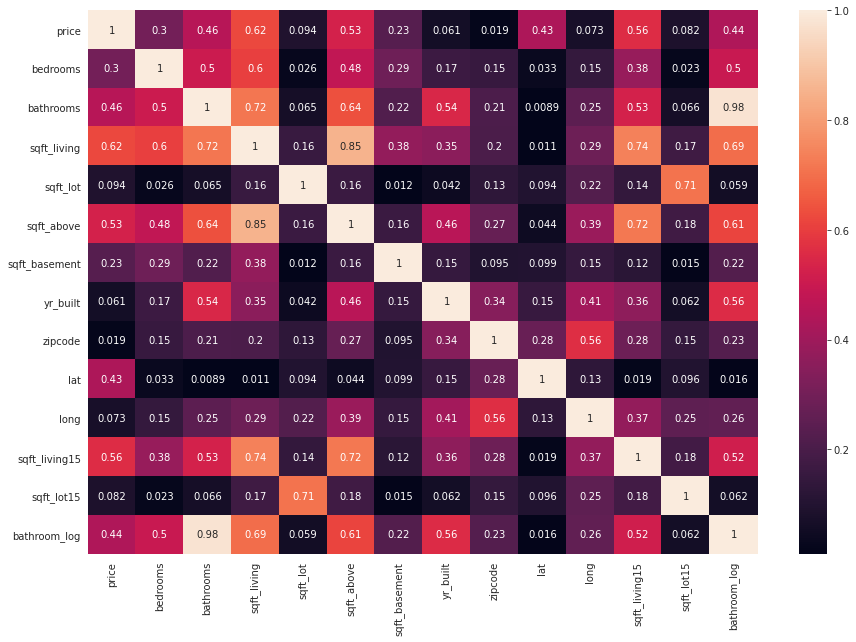

In [24]:
# sns.heatmap(df.corr(),annot=True)
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 10))
    ax = sns.heatmap(abs(df.corr()),annot=True)

Note the corelation between
- sqft_living and sqft_above (because sqft_living = sqft_above + sqft_basement). In fact a lot of the sqft are highly corelated
    - try feature engineering between them, or just pick 1 or 2
- grade to sqft_living15, sqft_above
- bathrooms to grade
- grade and sqft_living has highest impact on target (price)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20379 entries, 0 to 21596
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   price          20379 non-null  float64 
 1   bedrooms       20379 non-null  int64   
 2   bathrooms      20379 non-null  float64 
 3   sqft_living    20379 non-null  int64   
 4   sqft_lot       20379 non-null  int64   
 5   waterfront     18115 non-null  object  
 6   view           20379 non-null  object  
 7   condition      20379 non-null  object  
 8   grade          20379 non-null  object  
 9   sqft_above     20379 non-null  int64   
 10  sqft_basement  20379 non-null  int64   
 11  yr_built       20379 non-null  int64   
 12  zipcode        20379 non-null  int64   
 13  lat            20379 non-null  float64 
 14  long           20379 non-null  float64 
 15  sqft_living15  20379 non-null  int64   
 16  sqft_lot15     20379 non-null  int64   
 17  bedrooms_bin   20379 non-null  

In [225]:
df.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
bedrooms_bin     0
bathroom_log     0
dtype: int64

In [27]:
df.waterfront.isna().sum() / len(df)

0.11109475440404337

We'll have to keep an eye on the waterfront. Maybe drop the values? ~11% of data. Fill with 'NO'

In [28]:
df.waterfront = df.waterfront.fillna('NO')

In [29]:
df.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
bedrooms_bin     0
bathroom_log     0
dtype: int64

## Helper Functions

In [292]:
def OHE_scale_lr(X_train,y_train,
                 X_test,y_test,
                 
                 num_col,
                 cat_col =[]
                ):
    """
    Creates a pipeline to perform a 
    - One-Hot-Encoding (OHE)
    - Standard Scaling
    - Linear Regression

    cat_col = list of categorical column names to process with OHE. default empty list
    num_col = list of numerical column names
    
    Keep transformations out of this function. Function applid post train-test split
    """
    if not (cat_col or num_col):
        print("no columns provided to perform operations")
        return None
    
    #List Comp to get subst of columns
    list_cols= [col for sublist_cols in [num_col,cat_col]for col in sublist_cols]
    print('Categorical columns:',cat_col,'\nNumerical Columns: ',num_col)
    
    #Create subsets of train and test sets
    X_train_subset = X_train[list_cols]
    X_test_subset = X_test[list_cols]
    
    
    if cat_col:
        X_train_subset,X_test_subset = OHEColXFER(cat_col,X_train_subset, X_test_subset)
    
    pipe = make_pipeline(StandardScaler(), LinearRegression())
    pipe.fit(X_train_subset, y_train) 
    
    train_preds= pipe.predict(X_train_subset)
    test_preds = pipe.predict(X_test_subset)

    print("Training Score:",pipe.score(X_train_subset, y_train))
    print("Test Score:",pipe.score(X_test_subset, y_test))
    get_train_test_metrics(y_train,train_preds,y_test,test_preds)
    

    return X_train_enc,X_test_enc

In [289]:
def OHEColXFER(cat_col,X_train_subset, X_test_subset):
    """
    In place column transformation using One Hot Encoding 
    """ 
    
    #Instantiate Encoder
    encoder = OneHotEncoder(handle_unknown='error',
                            drop='first',
                            categories='auto')
    
    #Instantiate Column Transformer
    ct = ColumnTransformer(transformers=[('ohe', encoder, cat_col)],
                           remainder='passthrough')

    #Fit Column Transformer
    ct.fit(X_train_subset)

    #Get your encoded Training and Test sets. Sometimes need to force todens(0) depending upon size of output
    try:
        X_train_enc = ct.transform(X_train_subset).todense()
    except:
        X_train_enc = ct.transform(X_train_subset)
    
    try:
        X_test_enc = ct.transform(X_test_subset).todense()
    except:
        X_test_enc = ct.transform(X_test_subset)
    
    # Get a nice dataframe
    X_train_enc = pd.DataFrame(X_train_enc, columns=ct.get_feature_names())
    X_test_enc = pd.DataFrame(X_test_enc, columns=ct.get_feature_names())
    

In [288]:
def get_train_test_metrics(y_train,train_preds,
               y_test,test_preds
              ):
    """
    Prints different training and testing metrics, namely R2, MAE, MSE, RMSE
    """
    print("\nTraining Metrics:")
    # R2
    print(f"R2: {r2_score(y_train, train_preds):.3f}")
    # MAE
    print(f"Mean Absolute Error: {mean_absolute_error(y_train, train_preds):.3f}")
    # MSE
    print(f"Mean Squared Error: {mean_squared_error(y_train, train_preds):.3f}")
    # RMSE - just MSE but set squared=False
    print(f"Root Mean Squared Error: {mean_squared_error(y_train, train_preds, squared=False):.3f}")
    
    print("\nTesting Metrics:")
    # R2
    print(f"R2: {r2_score(y_test, test_preds):.3f}")
    # MAE
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, test_preds):.3f}")
    # MSE
    print(f"Mean Squared Error: {mean_squared_error(y_test, test_preds):.3f}")
    # RMSE - just MSE but set squared=False
    print(f"Root Mean Squared Error: {mean_squared_error(y_test, test_preds, squared=False):.3f}")

In [293]:
def ohe(df, df2, column):    
    for col in column:
        train = df[[col]]
        ohe = OneHotEncoder(drop="first", sparse=False, handle_unknown="error")
        ohe.fit(train)
        encoded_train = ohe.transform(train)
        col_names = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_train = pd.DataFrame(encoded_train,
                                     columns=col_names, index=df.index)
        df = pd.concat([df, encoded_train], axis=1)
        
        test = df2[[col]]
        encoded_test = ohe.transform(test)
        col_names = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_test = pd.DataFrame(encoded_test, 
                                    columns=col_names, index=df2.index)
        df2 = pd.concat([df2, encoded_test], axis=1)
    return df, df2, encoded_train.columns.tolist()

## Train Test split

In [31]:
# Define our X and y
X = df.drop(columns='price')
y = df['price']

In [32]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)

## Models

### Model 00. Dummy Regressor

In [33]:
dummy = DummyRegressor() #mean strategy

In [34]:
dummy.fit(X_train,y_train)

DummyRegressor()

In [35]:
dummy.score(X_train,y_train)

0.0

In [36]:
dummy.score(X_test,y_test)

-8.727889404758216e-06

Dummy Regressor has a 0 R^2 score?

### Model 0. Using highest corr coefficient feature: sqft_living

In [37]:
df.corr().price.sort_values()[-2:]

sqft_living    0.621509
price          1.000000
Name: price, dtype: float64

In [38]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living'],
                 cat_col =[]
                )

Categorical columns: [] 
Numerical Columns:  ['sqft_living']
Training Score: 0.38724291100841735
Test Score: 0.383954425521002

Training Metrics:
R2: 0.387
Mean Absolute Error: 131306.631
Mean Squared Error: 26535522450.985
Root Mean Squared Error: 162897.276

Testing Metrics:
R2: 0.384
Mean Absolute Error: 130433.433
Mean Squared Error: 26429196077.413
Root Mean Squared Error: 162570.588


Any chosen model **should perform better than this**

###  Model 1 : Sqft_living, grade

Note: These should have a high colinearity. Just curious

In [39]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living'],
                 cat_col =['grade']
                )

Categorical columns: ['grade'] 
Numerical Columns:  ['sqft_living']
Training Score: 0.4648671683087158
Test Score: 0.4625422103015142

Training Metrics:
R2: 0.465
Mean Absolute Error: 120082.686
Mean Squared Error: 23173994270.670
Root Mean Squared Error: 152230.070

Testing Metrics:
R2: 0.463
Mean Absolute Error: 119705.232
Mean Squared Error: 23057672834.168
Root Mean Squared Error: 151847.532


### Model 2: Sqft_living/Sqft_living15, grade

Feature engineering a ratio of living area to that of the neighborhood. Thinking: biggest house in the neighborhood is a good predicter

In [40]:
X_train['sqft_living/sqft_living15'] = X_train.sqft_living / X_train.sqft_living15
X_test['sqft_living/sqft_living15'] = X_test.sqft_living / X_test.sqft_living15

In [41]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living/sqft_living15'],
                 cat_col =['grade']
                )

Categorical columns: ['grade'] 
Numerical Columns:  ['sqft_living/sqft_living15']
Training Score: 0.4196360624662394
Test Score: 0.4160286064457098

Training Metrics:
R2: 0.420
Mean Absolute Error: 125151.232
Mean Squared Error: 25132732971.745
Root Mean Squared Error: 158533.066

Testing Metrics:
R2: 0.416
Mean Absolute Error: 124985.048
Mean Squared Error: 25053169932.921
Root Mean Squared Error: 158281.932


yeesh

### Model 3: Sqft_living, Sqft_lot,grade

Trying variations of Sqft_living and Sqft_lot
Thinking: Either individually, an addition or a ratio of the living/lot might be a good predicter

#### Model 3a: Sqft_living, Sqft_lot

In [42]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living','sqft_lot'],
                 cat_col =[]
                )

Categorical columns: [] 
Numerical Columns:  ['sqft_living', 'sqft_lot']
Training Score: 0.3872454358288966
Test Score: 0.38399515410064355

Training Metrics:
R2: 0.387
Mean Absolute Error: 131302.720
Mean Squared Error: 26535413113.318
Root Mean Squared Error: 162896.940

Testing Metrics:
R2: 0.384
Mean Absolute Error: 130426.689
Mean Squared Error: 26427448765.750
Root Mean Squared Error: 162565.214


probably also has high multicolinarity. Also, not much better than Model 0

#### Model 3b: Sqft_living + Sqft_lot, grade

In [43]:
X_train['sqft_living + sqft_lot'] = X_train['sqft_living'] + X_train['sqft_lot']
X_test['sqft_living + sqft_lot'] = X_test['sqft_living'] + X_test['sqft_lot']

In [44]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living + sqft_lot'],
                 cat_col =['grade']
                )

Categorical columns: ['grade'] 
Numerical Columns:  ['sqft_living + sqft_lot']
Training Score: 0.4079769573259926
Test Score: 0.40356186399196026

Training Metrics:
R2: 0.408
Mean Absolute Error: 126169.336
Mean Squared Error: 25637631979.469
Root Mean Squared Error: 160117.557

Testing Metrics:
R2: 0.404
Mean Absolute Error: 126117.183
Mean Squared Error: 25588010201.898
Root Mean Squared Error: 159962.527


#### Model 3c: Sqft_living / Sqft_lot, grade

In [45]:
X_train['sqft_living/sqft_lot'] = X_train['sqft_living'] / X_train['sqft_lot']
X_test['sqft_living/sqft_lot'] = X_test['sqft_living'] / X_test['sqft_lot']

In [46]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living/sqft_lot'],
                 cat_col =['grade']
                )

Categorical columns: ['grade'] 
Numerical Columns:  ['sqft_living/sqft_lot']
Training Score: 0.41033622239101974
Test Score: 0.4046987317863634

Training Metrics:
R2: 0.410
Mean Absolute Error: 126162.077
Mean Squared Error: 25535463710.467
Root Mean Squared Error: 159798.197

Testing Metrics:
R2: 0.405
Mean Absolute Error: 126204.669
Mean Squared Error: 25539237021.639
Root Mean Squared Error: 159810.003


Feature engineering betwen sqft_living and sqft_lot makes no diff

### Model 4: View, Waterfront, Grade

Something different. No square footage. Based on view, waterfront, grade. Will require little more work, since waterfront has a bunch of nulls

In [47]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = [],
                 cat_col =['view','waterfront','grade']
                )

Categorical columns: ['view', 'waterfront', 'grade'] 
Numerical Columns:  []
Training Score: 0.43041301439845836
Test Score: 0.43331507157376215

Training Metrics:
R2: 0.430
Mean Absolute Error: 123896.487
Mean Squared Error: 24666035719.134
Root Mean Squared Error: 157054.245

Testing Metrics:
R2: 0.433
Mean Absolute Error: 123385.669
Mean Squared Error: 24311556982.059
Root Mean Squared Error: 155921.637


Better, but meh. Marginally better than Model 0

### Model 5: Bedroom, Bathroom, sqft_living

ok. ignoring square footage probably not a good idea. Using room counts as a predicter

#### Model 5a

In [48]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['bedrooms','bathrooms','sqft_living'],
                 cat_col =[]
                )

Categorical columns: [] 
Numerical Columns:  ['bedrooms', 'bathrooms', 'sqft_living']
Training Score: 0.3954060646579909
Test Score: 0.395010827929423

Training Metrics:
R2: 0.395
Mean Absolute Error: 129877.861
Mean Squared Error: 26182016060.230
Root Mean Squared Error: 161808.578

Testing Metrics:
R2: 0.395
Mean Absolute Error: 128775.430
Mean Squared Error: 25954861321.563
Root Mean Squared Error: 161105.125


#### Model 5b

In [49]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['bathrooms','sqft_living'],
                 cat_col =['bedrooms_bin']
                )

Categorical columns: ['bedrooms_bin'] 
Numerical Columns:  ['bathrooms', 'sqft_living']
Training Score: 0.3973287992862705
Test Score: 0.3978523926036397

Training Metrics:
R2: 0.397
Mean Absolute Error: 129560.556
Mean Squared Error: 26098751796.442
Root Mean Squared Error: 161551.081

Testing Metrics:
R2: 0.398
Mean Absolute Error: 128346.720
Mean Squared Error: 25832954318.164
Root Mean Squared Error: 160726.334


Binning bedrooms has a marginal improvement

### Model 6: Bedroom, Bathroom, sqft_living, grade

#### Model 6a

In [50]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living','bedrooms','bathrooms'],
                 cat_col =['grade']
                )

Categorical columns: ['grade'] 
Numerical Columns:  ['sqft_living', 'bedrooms', 'bathrooms']
Training Score: 0.4674614117485075
Test Score: 0.46483662649616386

Training Metrics:
R2: 0.467
Mean Absolute Error: 119673.272
Mean Squared Error: 23061650233.732
Root Mean Squared Error: 151860.628

Testing Metrics:
R2: 0.465
Mean Absolute Error: 119344.193
Mean Squared Error: 22959239247.428
Root Mean Squared Error: 151523.065


In [51]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['bathrooms','sqft_living'],
                 cat_col =['grade','bedrooms_bin']
                )

Categorical columns: ['grade', 'bedrooms_bin'] 
Numerical Columns:  ['bathrooms', 'sqft_living']
Training Score: 0.4709729891310259
Test Score: 0.4692776624086721

Training Metrics:
R2: 0.471
Mean Absolute Error: 119076.255
Mean Squared Error: 22909580935.561
Root Mean Squared Error: 151359.112

Testing Metrics:
R2: 0.469
Mean Absolute Error: 118664.878
Mean Squared Error: 22768712744.551
Root Mean Squared Error: 150893.051


Getting better. Seems like better off treating bedrooms as cateogrical.

Hmmm... Including sqft_living AND grade increased scores. But their corelation is high. Probably high multicolinearity. Check a few more models

#### Model 6b: Bedroom/Bathroom, sqft_living, grade

Slight feature engineering. Ratio of bedrooms to bathrooms

In [52]:
X_train['bedrooms/bathrooms'] = X_train['bedrooms']/X_train['bathrooms']
X_test['bedrooms/bathrooms'] = X_test['bedrooms']/X_test['bathrooms']

In [53]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['bedrooms/bathrooms','sqft_living'],
                 cat_col =['grade']
                )

Categorical columns: ['grade'] 
Numerical Columns:  ['bedrooms/bathrooms', 'sqft_living']
Training Score: 0.4651352462013624
Test Score: 0.46229579903786167

Training Metrics:
R2: 0.465
Mean Absolute Error: 120089.391
Mean Squared Error: 23162385123.968
Root Mean Squared Error: 152191.935

Testing Metrics:
R2: 0.462
Mean Absolute Error: 119751.891
Mean Squared Error: 23068244213.743
Root Mean Squared Error: 151882.337


Not that much better

## Ze Kitchen Sink

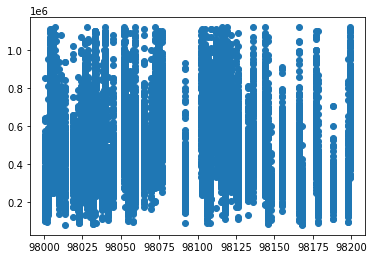

In [54]:
fig, ax = plt.subplots()
ax.scatter(df['zipcode'],df['price'])

If considering zip code, I think it should be considered as a categorical

### Model 7: zipcode included

#### Model 7a

In [55]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['zipcode','sqft_living','bathrooms',],
                 cat_col =['condition','bedrooms_bin',]
                )

Categorical columns: ['condition', 'bedrooms_bin'] 
Numerical Columns:  ['zipcode', 'sqft_living', 'bathrooms']
Training Score: 0.4180726745383633
Test Score: 0.41988591068317593

Training Metrics:
R2: 0.418
Mean Absolute Error: 127075.544
Mean Squared Error: 25200435681.685
Root Mean Squared Error: 158746.451

Testing Metrics:
R2: 0.420
Mean Absolute Error: 126061.119
Mean Squared Error: 24887686315.725
Root Mean Squared Error: 157758.316


#### Model 7b

In [56]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living','bathrooms',],
                 cat_col =['bedrooms_bin','zipcode','condition']
                )

Categorical columns: ['bedrooms_bin', 'zipcode', 'condition'] 
Numerical Columns:  ['sqft_living', 'bathrooms']
Training Score: 0.7816866799105319
Test Score: 0.7793184856963282

Training Metrics:
R2: 0.782
Mean Absolute Error: 70556.144
Mean Squared Error: 9454085657.527
Root Mean Squared Error: 97232.123

Testing Metrics:
R2: 0.779
Mean Absolute Error: 70530.560
Mean Squared Error: 9467538204.661
Root Mean Squared Error: 97301.275


PROMISING! 

$_{only~thing~so~far}$

#### Model 7c

In [57]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['bedrooms','bathrooms','sqft_living'],
                 cat_col =['zipcode','condition']
                )

Categorical columns: ['zipcode', 'condition'] 
Numerical Columns:  ['bedrooms', 'bathrooms', 'sqft_living']
Training Score: 0.7802146757403439
Test Score: 0.7776438037827154

Training Metrics:
R2: 0.780
Mean Absolute Error: 70839.792
Mean Squared Error: 9517830982.400
Root Mean Squared Error: 97559.372

Testing Metrics:
R2: 0.778
Mean Absolute Error: 70752.915
Mean Squared Error: 9539384344.777
Root Mean Squared Error: 97669.772


#### Model 7d

In [58]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living'],
                 cat_col =['zipcode','condition','view','waterfront']
                )

Categorical columns: ['zipcode', 'condition', 'view', 'waterfront'] 
Numerical Columns:  ['sqft_living']
Training Score: 0.7931173026009083
Test Score: 0.7917688586649669

Training Metrics:
R2: 0.793
Mean Absolute Error: 69062.111
Mean Squared Error: 8959081110.899
Root Mean Squared Error: 94652.423

Testing Metrics:
R2: 0.792
Mean Absolute Error: 69274.233
Mean Squared Error: 8933400208.940
Root Mean Squared Error: 94516.666


#### Model 7e

In [59]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['bedrooms','bathrooms','sqft_living'],
                 cat_col =['zipcode','condition','view']
                )

Categorical columns: ['zipcode', 'condition', 'view'] 
Numerical Columns:  ['bedrooms', 'bathrooms', 'sqft_living']
Training Score: 0.7945302524189559
Test Score: 0.7935742186271572

Training Metrics:
R2: 0.795
Mean Absolute Error: 68766.994
Mean Squared Error: 8897893142.139
Root Mean Squared Error: 94328.644

Testing Metrics:
R2: 0.794
Mean Absolute Error: 68947.547
Mean Squared Error: 8855947802.157
Root Mean Squared Error: 94106.046


#### Model 7f

In [60]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['bathrooms','sqft_living','sqft_living15'],
                 cat_col =['zipcode','condition','view','bedrooms_bin',]
                )

Categorical columns: ['zipcode', 'condition', 'view', 'bedrooms_bin'] 
Numerical Columns:  ['bathrooms', 'sqft_living', 'sqft_living15']
Training Score: 0.8065356057116359
Test Score: 0.8076516489894374

Training Metrics:
R2: 0.807
Mean Absolute Error: 66597.849
Mean Squared Error: 8377999814.827
Root Mean Squared Error: 91531.414

Testing Metrics:
R2: 0.808
Mean Absolute Error: 66378.232
Mean Squared Error: 8252006823.236
Root Mean Squared Error: 90840.557


Best one yet

In [61]:
df.yr_built.isna().sum()

0

In [62]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living','sqft_living15'],
                 cat_col =['zipcode','condition','view','bedrooms_bin']
                )

Categorical columns: ['zipcode', 'condition', 'view', 'bedrooms_bin'] 
Numerical Columns:  ['sqft_living', 'sqft_living15']
Training Score: 0.8060652678972853
Test Score: 0.8070565881346724

Training Metrics:
R2: 0.806
Mean Absolute Error: 66638.380
Mean Squared Error: 8398367852.759
Root Mean Squared Error: 91642.609

Testing Metrics:
R2: 0.807
Mean Absolute Error: 66438.684
Mean Squared Error: 8277535746.193
Root Mean Squared Error: 90980.964


## Deepdive in Model 7f

Get all the necessary variables (R^2, Condition No, p-values, coeffiencts, intercept)

### First a sanity check. Manual Run of methods

In [353]:
cols = ['sqft_living','sqft_living15','zipcode','condition','view','bedrooms_bin']
cat_col =['zipcode','condition','view','bedrooms_bin']
X_train_subset = X_train[cols]
X_test_subset = X_test[cols]

In [354]:
cs=[]

X_train_subset,X_test_subset,c = ohe(X_train_subset,X_test_subset,['zipcode'])
cs = cs + c
X_train_subset,X_test_subset,c = ohe(X_train_subset,X_test_subset,['condition'])
cs = cs + c
X_train_subset,X_test_subset,c = ohe(X_train_subset,X_test_subset,['view'])
cs = cs + c
X_train_subset,X_test_subset,c = ohe(X_train_subset,X_test_subset,['bedrooms_bin'])
cs = cs + c

cs = cs +['sqft_living','sqft_living15']
X_train_enc = X_train_subset[cs]
X_test_enc = X_test_subset[cs]

In [357]:
X_train_enc

,zipcode_x0_98002,zipcode_x0_98003,zipcode_x0_98004,zipcode_x0_98005,zipcode_x0_98006,zipcode_x0_98007,zipcode_x0_98008,zipcode_x0_98010,zipcode_x0_98011,zipcode_x0_98014,...,view_x0_GOOD,view_x0_NONE,bedrooms_bin_x0_2BR,bedrooms_bin_x0_3BR,bedrooms_bin_x0_4BR,bedrooms_bin_x0_5BR,bedrooms_bin_x0_6BR,bedrooms_bin_x0_7+BR,sqft_living,sqft_living15
4535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3380,2250
14745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1330,1400
19299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1120,1620
20872,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1230,1230
9182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1110,1230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4690,2910
12650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1740,1260
5700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1880,2520
909,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1420,1660


In [336]:
encoder = OneHotEncoder(handle_unknown='error',
                        drop='first',
                        categories='auto')
ct = ColumnTransformer(transformers=[('ohe', encoder, cat_col)],
                           remainder='passthrough')

#Fit Column Transformer
ct.fit(X_train_subset)

#Get your encoded Training and Test sets. Sometimes need to force todens(0) depending upon size of output
try:
    X_train_enc = ct.transform(X_train_subset).todense()    
except:
    X_train_enc = ct.transform(X_train_subset)

try:
    X_test_enc = ct.transform(X_test_subset).todense()
except:
    X_test_enc = ct.transform(X_test_subset)


In [356]:
#Scale
scaler = StandardScaler() #IQR and scaled
scaler.fit(X_train_enc)
X_train_scaled = scaler.transform(X_train_enc)
X_test_scaled = scaler.transform(X_test_enc)

In [359]:
#Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled,y_train)

LinearRegression()

In [360]:
train_preds=lr.predict(X_train_scaled)
test_preds=lr.predict(X_test_scaled)

train_residuals = y_train - train_preds
test_residuals = y_test - test_preds

In [361]:
get_train_test_metrics(y_train,train_preds,y_test,test_preds)


Training Metrics:
R2: 0.806
Mean Absolute Error: 66638.380
Mean Squared Error: 8398367852.759
Root Mean Squared Error: 91642.609

Testing Metrics:
R2: 0.807
Mean Absolute Error: 66438.684
Mean Squared Error: 8277535746.193
Root Mean Squared Error: 90980.964


In [362]:
90980.964/df.price.median()

0.20795648914285716

In [363]:
90980.964/df.price.mean()

0.19085374783709685

Roughly 20% error predicting prices when compared to meadian house price

In [365]:
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train_subset.index, columns=cs)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test_subset.index, columns=cs)

In [366]:
X_train_scaled

,zipcode_x0_98002,zipcode_x0_98003,zipcode_x0_98004,zipcode_x0_98005,zipcode_x0_98006,zipcode_x0_98007,zipcode_x0_98008,zipcode_x0_98010,zipcode_x0_98011,zipcode_x0_98014,...,view_x0_GOOD,view_x0_NONE,bedrooms_bin_x0_2BR,bedrooms_bin_x0_3BR,bedrooms_bin_x0_4BR,bedrooms_bin_x0_5BR,bedrooms_bin_x0_6BR,bedrooms_bin_x0_7+BR,sqft_living,sqft_living15
4535,-0.100272,-0.11985,-0.090545,-0.083171,-0.139682,-0.081008,-0.111123,-0.07172,-0.098474,-0.080568,...,-0.134372,0.288774,-0.395201,1.074783,-0.674881,-0.264541,-0.103087,-0.048879,1.807660,0.529523
14745,-0.100272,-0.11985,-0.090545,-0.083171,-0.139682,-0.081008,-0.111123,-0.07172,-0.098474,-0.080568,...,-0.134372,0.288774,-0.395201,1.074783,-0.674881,-0.264541,-0.103087,-0.048879,-0.835415,-0.848443
19299,-0.100272,-0.11985,-0.090545,-0.083171,-0.139682,-0.081008,-0.111123,-0.07172,-0.098474,-0.080568,...,-0.134372,-3.462918,-0.395201,1.074783,-0.674881,-0.264541,-0.103087,-0.048879,-1.106169,-0.491793
20872,-0.100272,-0.11985,-0.090545,-0.083171,-0.139682,-0.081008,-0.111123,-0.07172,-0.098474,-0.080568,...,-0.134372,0.288774,2.530355,-0.930420,-0.674881,-0.264541,-0.103087,-0.048879,-0.964345,-1.124037
9182,-0.100272,-0.11985,-0.090545,-0.083171,-0.139682,-0.081008,-0.111123,-0.07172,-0.098474,-0.080568,...,-0.134372,0.288774,-0.395201,-0.930420,-0.674881,-0.264541,-0.103087,-0.048879,-1.119062,-1.124037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11933,-0.100272,-0.11985,-0.090545,-0.083171,-0.139682,-0.081008,-0.111123,-0.07172,-0.098474,-0.080568,...,-0.134372,-3.462918,-0.395201,-0.930420,1.481744,-0.264541,-0.103087,-0.048879,3.496649,1.599474
12650,-0.100272,-0.11985,-0.090545,-0.083171,-0.139682,-0.081008,-0.111123,-0.07172,-0.098474,-0.080568,...,-0.134372,0.288774,-0.395201,1.074783,-0.674881,-0.264541,-0.103087,-0.048879,-0.306800,-1.075402
5700,-0.100272,-0.11985,-0.090545,-0.083171,-0.139682,-0.081008,-0.111123,-0.07172,-0.098474,-0.080568,...,-0.134372,0.288774,-0.395201,1.074783,-0.674881,-0.264541,-0.103087,-0.048879,-0.126297,0.967230
909,9.972850,-0.11985,-0.090545,-0.083171,-0.139682,-0.081008,-0.111123,-0.07172,-0.098474,-0.080568,...,-0.134372,0.288774,-0.395201,1.074783,-0.674881,-0.264541,-0.103087,-0.048879,-0.719377,-0.426948


### OLS Summary

In [367]:
#Just to get summary
model = sm.OLS(endog=y_train, exog=sm.add_constant(X_train_scaled)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     693.3
Date:                Wed, 30 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:06:51   Log-Likelihood:            -1.8323e+05
No. Observations:               14265   AIC:                         3.666e+05
Df Residuals:                   14179   BIC:                         3.673e+05
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   4.765e+05    769.617    619.152      0.000    4.75e+05    4.78e+05
zipcode_x0_98002        1087.5877    963.471      1.129      0.259    -800.943    2976.118
zipcode_x0_98003        -188.6870   1030.522     -0.183      0.855   -2208.646    1831.272
zipcode_x0_98004        4.584e+04    933.200     49.123      0.000     4.4e+04    4.77e+04
zipcode_x0_98005        2.821e+04    912.877     30.901      0.000    2.64e+04       3e+04
zipcode_x0_98006        3.863e+04   1116.506     34.603      0.000    3.64e+04    4.08e+04
zipcode_x0_98007        2.226e+04    902.952     24.649      0.000    2.05e+04     2.4e+04
zipcode_x0_98008        2.719e+04   1000.543     27.173      0.000    2.52e+04    2.91e+04
zipcode_x0_98010        6671.6699    874.402      7.630      0.000    4957.728    8385.612
zipcode_x0_98011        1.426e+04    957.502     14.894      0.000    1.24e+04    1.61e+04
zipcode_x0_98014        1.059e+04    900.587     11.756      0.000    8821.757    1.24e+04
zipcode_x0_98019        9722.8733    960.129     10.127      0.000    7840.893    1.16e+04
zipcode_x0_98022        2647.8176    988.467      2.679      0.007     710.293    4585.342
zipcode_x0_98023       -2664.8516   1188.023     -2.243      0.025   -4993.532    -336.171
zipcode_x0_98024        1.057e+04    840.096     12.584      0.000    8925.267    1.22e+04
zipcode_x0_98027        2.704e+04   1102.392     24.527      0.000    2.49e+04    2.92e+04
zipcode_x0_98028        1.589e+04   1033.159     15.384      0.000    1.39e+04    1.79e+04
zipcode_x0_98029        3.126e+04   1061.685     29.440      0.000    2.92e+04    3.33e+04
zipcode_x0_98030         293.7965   1007.300      0.292      0.771   -1680.645    2268.238
zipcode_x0_98031        1423.1893   1004.424      1.417      0.157    -545.614    3391.993
zipcode_x0_98032         300.2702    896.492      0.335      0.738   -1456.971    2057.512
zipcode_x0_98033        4.371e+04   1092.311     40.018      0.000    4.16e+04    4.59e+04
zipcode_x0_98034         3.02e+04   1195.181     25.268      0.000    2.79e+04    3.25e+04
zipcode_x0_98038        6686.9222   1241.313      5.387      0.000    4253.786    9120.058
zipcode_x0_98039        9409.2774    774.853     12.143      0.000    7890.464    1.09e+04
zipcode_x0_98040        3.861e+04    942.595     40.964      0.000    3.68e+04    4.05e+04
zipcode_x0_98042        1969.2050   1225.625      1.607      0.108    -433.180    4371.590
zipcode_x0_98045        1.349e+04    978.796     13.785      0.000    1.16e+04    1.54e+04
zipcode_x0_98052        4.412e+04   1225.864     35.995      0.000    4.17e+04    4.65e+04
zipcode_x0_98053        3.459e+04   1110.856     31.136      0.000    3.24e+04    3.68e+04
zipcode_x0_98055        5049.4612   1016.247      4.969      0.000    3057.484  

In [313]:
#Just to get summary
model = sm.OLS(endog=y_test, exog=sm.add_constant(X_test_scaled)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     303.8
Date:                Wed, 30 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:46:42   Log-Likelihood:                -78429.
No. Observations:                6114   AIC:                         1.570e+05
Df Residuals:                    6028   BIC:                         1.576e+05
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              4.763e+05   1173.035    406.014      0.000    4.74e+05    4.79e+05
ohe__x0_98002      -322.7406   1473.634     -0.219      0.827   -3211.591    2566.110
ohe__x0_98003      1831.8475   1585.366      1.155      0.248   -1276.037    4939.732
ohe__x0_98004      4.751e+04   1557.879     30.494      0.000    4.45e+04    5.06e+04
ohe__x0_98005      2.896e+04   1250.972     23.148      0.000    2.65e+04    3.14e+04
ohe__x0_98006      3.953e+04   1631.888     24.224      0.000    3.63e+04    4.27e+04
ohe__x0_98007      2.274e+04   1305.433     17.418      0.000    2.02e+04    2.53e+04
ohe__x0_98008       2.79e+04   1412.270     19.753      0.000    2.51e+04    3.07e+04
ohe__x0_98010      7557.7648   1390.789      5.434      0.000    4831.320    1.03e+04
ohe__x0_98011      1.369e+04   1447.170      9.460      0.000    1.09e+04    1.65e+04
ohe__x0_98014      8889.0265   1517.032      5.859      0.000    5915.101    1.19e+04
ohe__x0_98019      1.003e+04   1527.308      6.567      0.000    7036.510     1.3e+04
ohe__x0_98022      1049.2166   1472.573      0.713      0.476   -1837.553    3935.986
ohe__x0_98023     -2678.1912   1816.048     -1.475      0.140   -6238.294     881.911
ohe__x0_98024      8775.6857   1184.689      7.408      0.000    6453.272    1.11e+04
ohe__x0_98027      2.594e+04   1595.257     16.262      0.000    2.28e+04    2.91e+04
ohe__x0_98028      1.493e+04   1607.884      9.288      0.000    1.18e+04    1.81e+04
ohe__x0_98029      3.153e+04   1658.067     19.015      0.000    2.83e+04    3.48e+04
ohe__x0_98030      1691.1412   1529.898      1.105      0.269   -1308.006    4690.288
ohe__x0_98031      1134.4400   1417.025      0.801      0.423   -1643.436    3912.316
ohe__x0_98032     -1571.2733   1410.935     -1.114      0.265   -4337.210    1194.663
ohe__x0_98033      4.475e+04   1637.228     27.331      0.000    4.15e+04     4.8e+04
ohe__x0_98034      2.869e+04   1769.920     16.211      0.000    2.52e+04    3.22e+04
ohe__x0_98038      5474.5751   1862.961      2.939      0.003    1822.506    9126.645
ohe__x0_98039      9273.8563    770.303     12.039      0.000    7763.788    1.08e+04
ohe__x0_98040      4.048e+04   1469.449     27.549      0.000    3.76e+04    4.34e+04
ohe__x0_98042      1823.7882   1876.543      0.972      0.331   -1854.907    5502.483
ohe__x0_98045      1.189e+04   1498.028      7.940      0.000    8958.029    1.48e+04
ohe__x0_98052      4.287e+04   1817.249     23.591      0.000    3.93e+04    4.64e+04
ohe__x0_98053       3.22e+04   1661.670     19.379      0.000    2.89e+04    3.55e+04
ohe__x0_98055      4290.7233   1528.242      2.808      0.005    1294.822    7286.625
ohe__x0_98056      1.481e+04   1669.038      8.874      0.000    1.15e+04    1.81e+04
ohe__x0_98058      5617.6924   1643.225      3.419      0.001    2396.383

In [315]:
model.params

const            476268.150655
ohe__x0_98002      -322.740574
ohe__x0_98003      1831.847541
ohe__x0_98004     47505.687225
ohe__x0_98005     28957.017001
                     ...      
ohe__x3_5BR      -11225.047721
ohe__x3_6BR       -5579.061728
ohe__x3_7+BR      -8912.872352
sqft_living      101040.031454
sqft_living15     38906.266747
Length: 86, dtype: float64

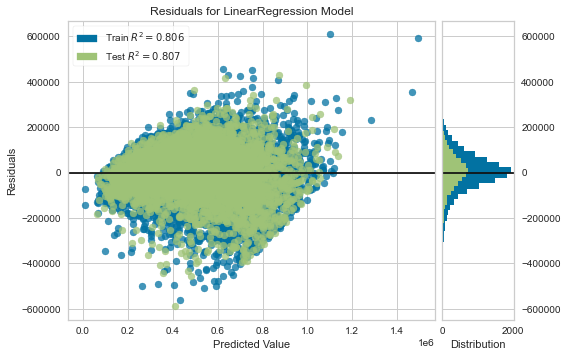

In [316]:
# visualizing our residuals 
# https://www.scikit-yb.org/en/latest/api/regressor/residuals.html
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(lr)

visualizer.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
visualizer.show()  
plt.show()

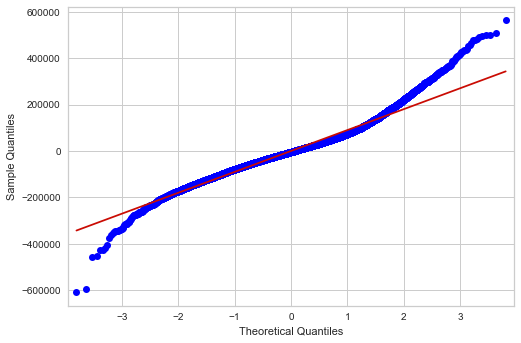

In [317]:
sm.qqplot(train_residuals, line = 'r');

Makes intuitive sense. Intercept around 470k. Houses around King County are expensive: mean 540k, median: 450k

Some zip codes have a much higher impact on prices. pricier neighborhoods

In [320]:
X_train_subset.sqft_living

4535     3380
14745    1330
19299    1120
20872    1230
9182     1110
         ... 
11933    4690
12650    1740
5700     1880
909      1420
16714    1730
Name: sqft_living, Length: 14265, dtype: int64

## LOG (Price)

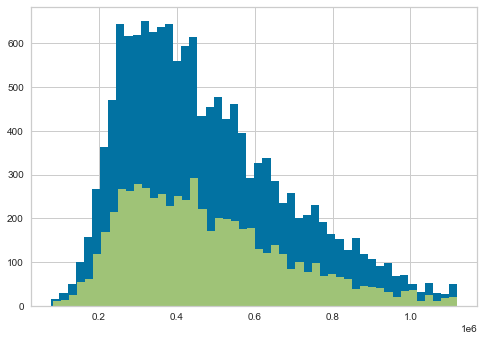

In [113]:
plt.hist(y_train,bins = 50)
plt.hist(y_test,bins = 50);

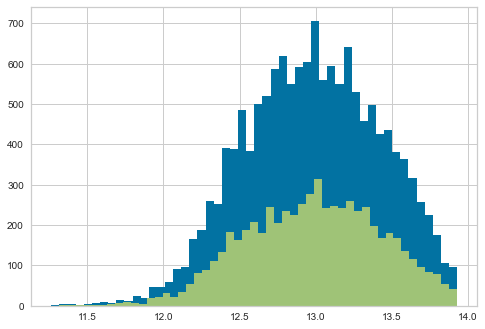

In [114]:
plt.hist(np.log(y_train),bins = 50)
plt.hist(np.log(y_test),bins = 50);

In [123]:
#USE encoded training and test  sets here!
log_y_train = np.log(y_train)
log_y_test = np.log(y_test)

pipe_log = make_pipeline(RobustScaler(), LinearRegression())
pipe_log.fit(X_train_enc, log_y_train) 
print("Training Score:",pipe_log.score(X_train_enc, log_y_train))
print("Test Score:",pipe_log.score(X_test_enc, log_y_test))

Training Score: 0.8169562330085769
Test Score: 0.8163125889256978


In [124]:
train_preds = pipe_log.predict(X_train_enc)
test_preds = pipe_log.predict(X_test_enc)

train_residuals = log_y_train - train_preds
test_residuals = log_y_test - test_preds

In [125]:
get_train_test_metrics(log_y_train,train_preds,
                      log_y_test,test_preds)


Training Metrics:
R2: 0.817
Mean Absolute Error: 0.140
Mean Squared Error: 0.036
Root Mean Squared Error: 0.191

Testing Metrics:
R2: 0.816
Mean Absolute Error: 0.140
Mean Squared Error: 0.036
Root Mean Squared Error: 0.191


In [122]:
np.exp(0.191)

1.2104594520812995

In [126]:
get_train_test_metrics(np.exp(log_y_train),np.exp(train_preds),
                      np.exp(log_y_test),np.exp(test_preds))


Training Metrics:
R2: 0.772
Mean Absolute Error: 65951.003
Mean Squared Error: 9860060981.484
Root Mean Squared Error: 99297.840

Testing Metrics:
R2: 0.791
Mean Absolute Error: 65396.949
Mean Squared Error: 8971457626.737
Root Mean Squared Error: 94717.779


In [118]:
#Just to get summary
model = sm.OLS(endog=log_y_train, exog=sm.add_constant(X_train_scaled)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     744.5
Date:                Wed, 30 Mar 2022   Prob (F-statistic):               0.00
Time:                        13:36:52   Log-Likelihood:                 3404.6
No. Observations:               14265   AIC:                            -6637.
Df Residuals:                   14179   BIC:                            -5987.
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.9782      0.002   8108.258      0.000      12.975      12.981
x1            -0.0038      0.002     -1.888      0.059      -0.008       0.000
x2             0.0026      0.002      1.213      0.225      -0.002       0.007
x3             0.0926      0.002     47.703      0.000       0.089       0.096
x4             0.0616      0.002     32.436      0.000       0.058       0.065
x5             0.0884      0.002     38.053      0.000       0.084       0.093
x6             0.0553      0.002     29.446      0.000       0.052       0.059
x7             0.0710      0.002     34.130      0.000       0.067       0.075
x8             0.0191      0.002     10.513      0.000       0.016       0.023
x9             0.0433      0.002     21.720      0.000       0.039       0.047
x10            0.0285      0.002     15.220      0.000       0.025       0.032
x11            0.0323      0.002     16.173      0.000       0.028       0.036
x12            0.0093      0.002      4.542      0.000       0.005       0.013
x13           -0.0040      0.002     -1.604      0.109      -0.009       0.001
x14            0.0272      0.002     15.545      0.000       0.024       0.031
x15            0.0707      0.002     30.820      0.000       0.066       0.075
x16            0.0488      0.002     22.706      0.000       0.045       0.053
x17            0.0806      0.002     36.491      0.000       0.076       0.085
x18            0.0046      0.002      2.180      0.029       0.000       0.009
x19            0.0085      0.002      4.088      0.000       0.004       0.013
x20           -0.0016      0.002     -0.853      0.394      -0.005       0.002
x21            0.1012      0.002     44.527      0.000       0.097       0.106
x22            0.0826      0.002     33.248      0.000       0.078       0.088
x23            0.0286      0.003     11.095      0.000       0.024       0.034
x24            0.0185      0.002     11.468      0.000       0.015       0.022
x25            0.0776      0.002     39.566      0.000       0.074       0.081
x26            0.0104      0.003      4.085      0.000       0.005       0.015
x27            0.0383      0.002     18.809      0.000       0.034       0.042
x28            0.1073      0.003     42.101      0.000       0.102       0.112
x29            0.0845      0.002     36.564      0.000       0.080       0.089
x30            0.0136      0.002      6.446      0.000       0.009       0.018
x31            0.0409      0.002     17.610      0.000       0.036       0.045
x32            0.0277      0.002     11.722      0.000       0.023       0.032
x33            0.0498      0.002     20.781      0.000       0.045       0.055
x34            0.0421      0.002     19.542      0.000       0.038       0.046
x35            0.0349      0.002     18.782      0.000       0.031       0.039
x3

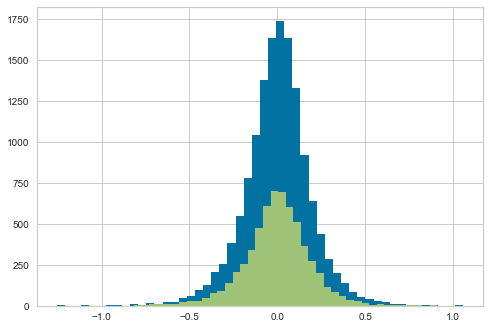

In [119]:
plt.hist(train_residuals,bins = 50);
plt.hist(test_residuals,bins = 50);

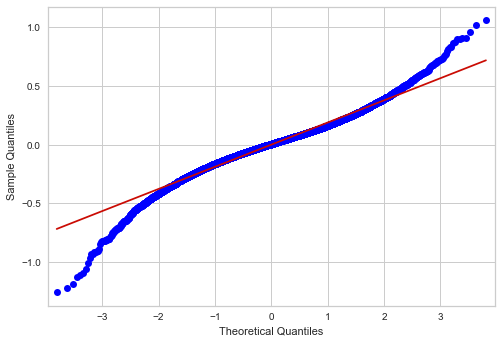

In [127]:
sm.qqplot(train_residuals, line = 'r');

WORSE!

## Some weird plots

In [81]:
df_pairplotting1 = df.filter(['bedrooms','bathrooms','floors','view','condition','price'])
df_pairplotting2 = df.filter(['bedrooms','sqft_living', 'sqft_lot','sqft_above','sqft_living15', 'sqft_lot15','price'])

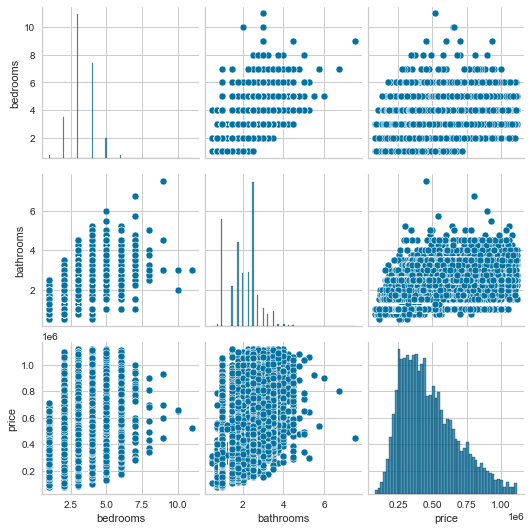

In [82]:
sns.pairplot(df_pairplotting1)

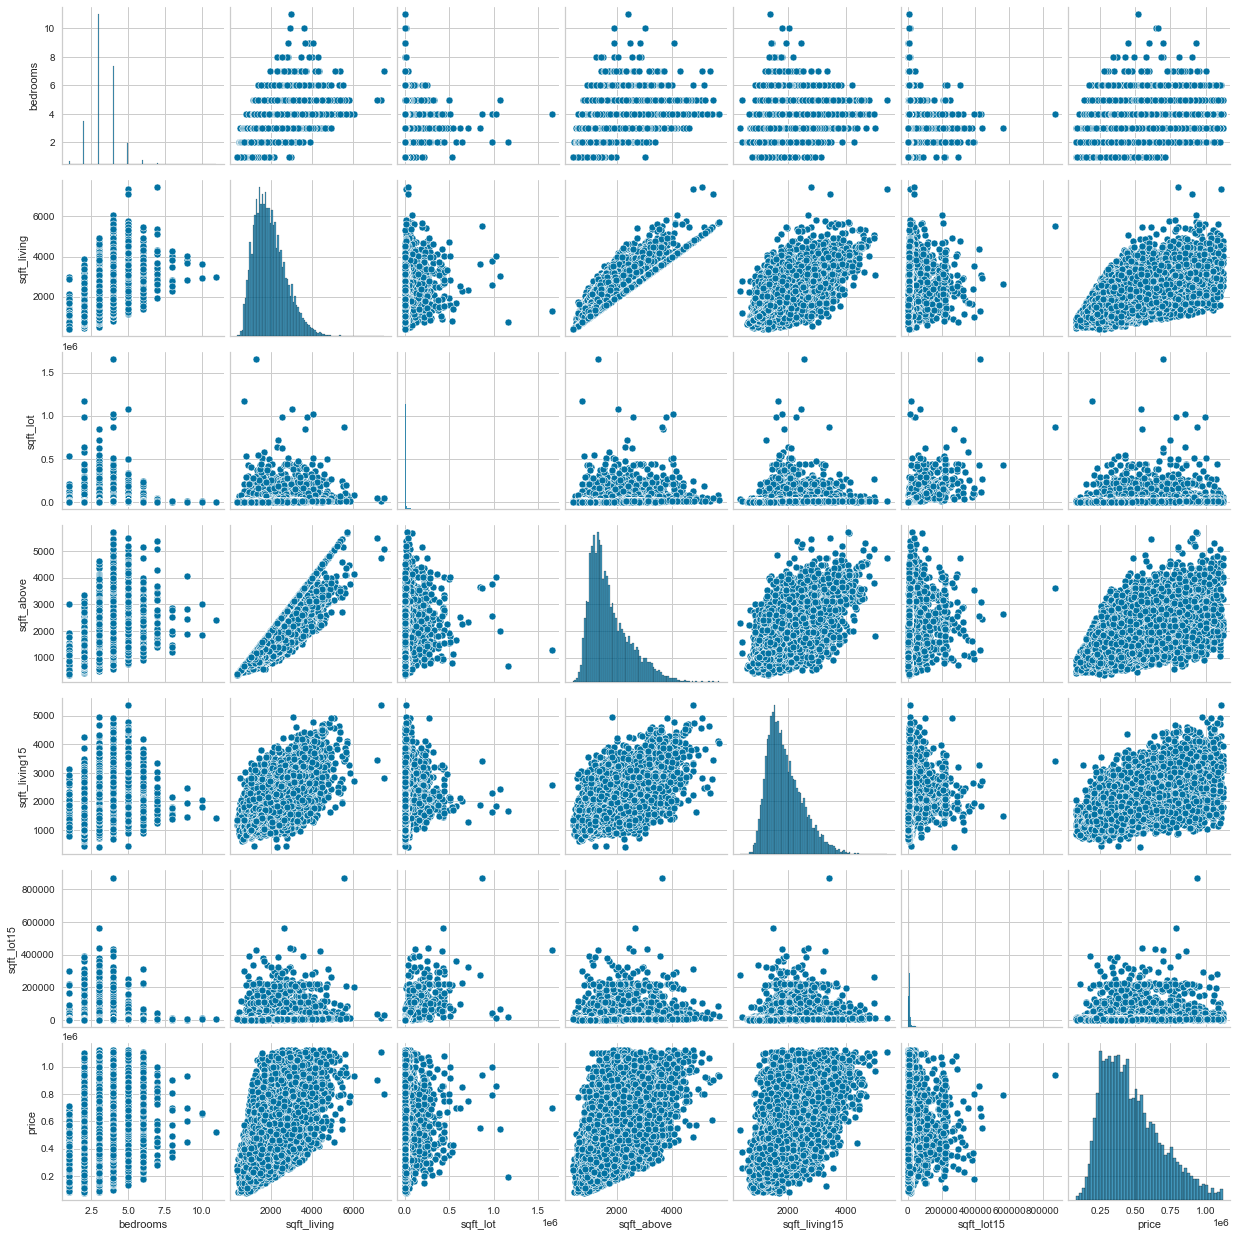

In [83]:
sns.pairplot(df_pairplotting2)